Performance Analysis


In [1]:
import os
import string
import random
import paramiko
import pandas as pd
from scp import SCPClient
from posixpath import join
import matplotlib.pyplot as plt

run_id = 11
n_reducers = 3
methods = ['combiner', 'inmappercombiner']

jar_name = 'letter-frequency-1.0-SNAPSHOT.jar'
hdfs_dir = '/user/hadoop/performance_analysis'
local_dir = '../resources/performance_analysis/'
local_input_dir = local_dir + 'input'

c:\Users\Utente\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


1. generate text files with random letters for performance analysis

In [2]:
# file size in bytes
sizes = [10 * 1024, 1 * 1024 * 1024, 100 * 1024 * 1024, 1 * 1024 * 1024 * 1024]
chunk_size = 100 

# file names
filenames = [os.path.join(local_input_dir, "10KB.txt"), 
             os.path.join(local_input_dir, "1MB.txt"), 
             os.path.join(local_input_dir, "100MB.txt"), 
             os.path.join(local_input_dir, "1GB.txt")]

# generate a string of random letters
def generate_random_string(length):
    letters = string.ascii_letters
    return ''.join(random.choice(letters) for i in range(length))

for size, filename in zip(sizes, filenames):
    print(f"Generating {filename}...")
    if(os.path.exists(filename)):
        continue
    with open(filename, 'w') as f:
        for _ in range(size // chunk_size):
            f.write(generate_random_string(chunk_size))
            f.write('\n')
        remaining = size % chunk_size
        if remaining:
            f.write(generate_random_string(remaining))
    print(f"File {filename} generated successfully.")

Generating ../resources/performance_analysis/input\10KB.txt...
Generating ../resources/performance_analysis/input\1MB.txt...
Generating ../resources/performance_analysis/input\100MB.txt...
Generating ../resources/performance_analysis/input\1GB.txt...


2. for each combination of method and number of reducers, run the application for each text file

In [ ]:
# connect with ssh
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('10.1.1.124', username='hadoop', password='ubuntu')

# try all the combinations of methods and reducers
for method in methods:
    for i in range(1, n_reducers+1):
        for txt_file in os.listdir(local_input_dir):
            print(f'Processing {txt_file} with {method} and {i} reducers')
            
            hdfs_input_dir = join(hdfs_dir, 'input', txt_file)
            hdfs_output_dir = join(hdfs_dir, f'output_{run_id}', f'{method}_{i}', txt_file.split('.')[0])
            ssh.exec_command(f'mkdir -p output_{run_id}/{method}_{i}')

            stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop jar {jar_name} it.unipi.cloud.MapReduceApp '
                                                     f'{hdfs_input_dir} {hdfs_output_dir}/count {hdfs_output_dir}/freq {i} {method} '
                                                     f'> log.txt 2>&1')
            stderr.read().decode('utf-8')
            
            # copy from hdfs to virtual machine
            stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop fs -copyToLocal {hdfs_output_dir} output_{run_id}/{method}_{i}' )
            stderr.read().decode('utf-8')
            stdin, stdout, stderr = ssh.exec_command(f'mv log.txt output_{run_id}/{method}_{i}/{txt_file.split(".")[0]}/log.txt')
            stderr.read().decode('utf-8')
            
# copy from virtual machine to local machine
if not os.path.exists(f'{local_dir}output_{run_id}'):
    os.makedirs(f'{local_dir}output_{run_id}', )
scp = SCPClient(ssh.get_transport())
scp.get(f'output_{run_id}', local_dir, recursive=True)
        
# remove the output from virtual machine
ssh.exec_command(f'rm -r output_{run_id}')

scp.close()
ssh.close()

3. plot the results for a specific list of parameters

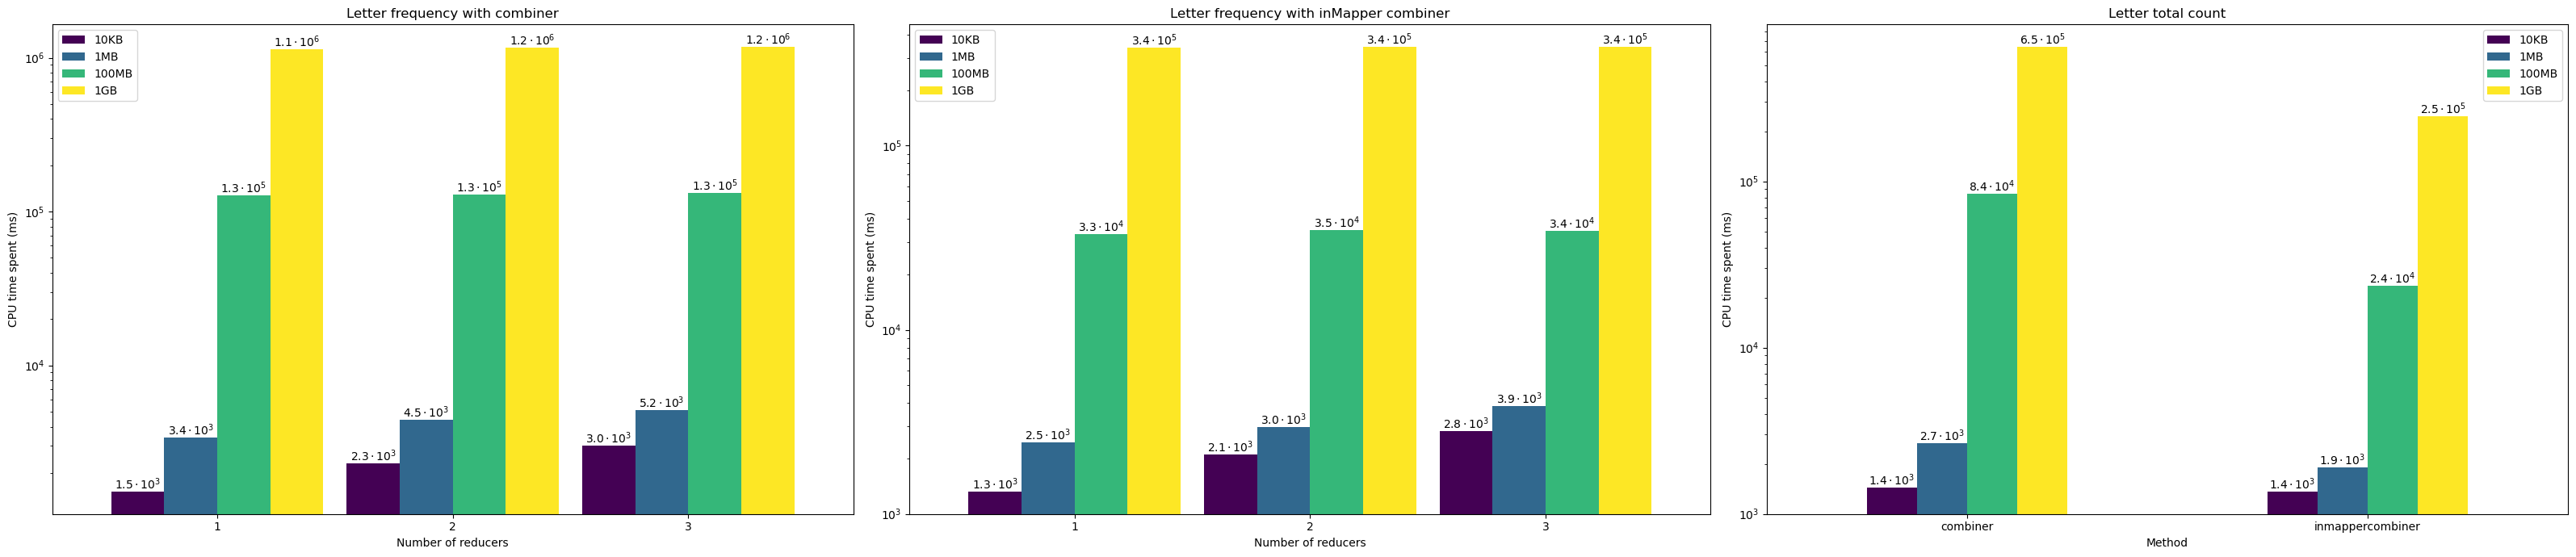

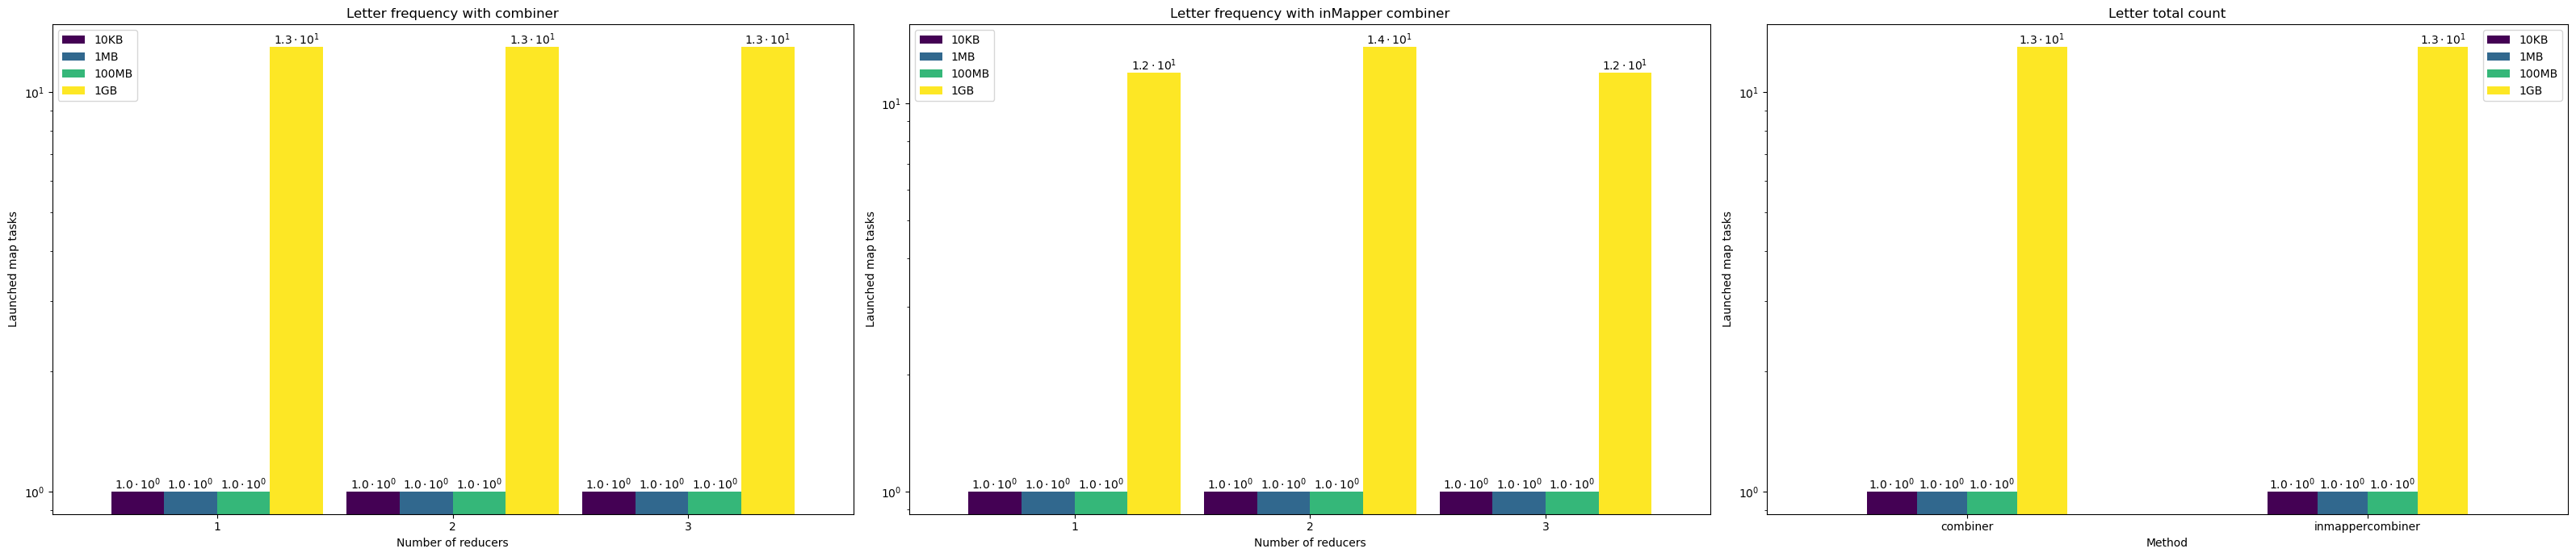

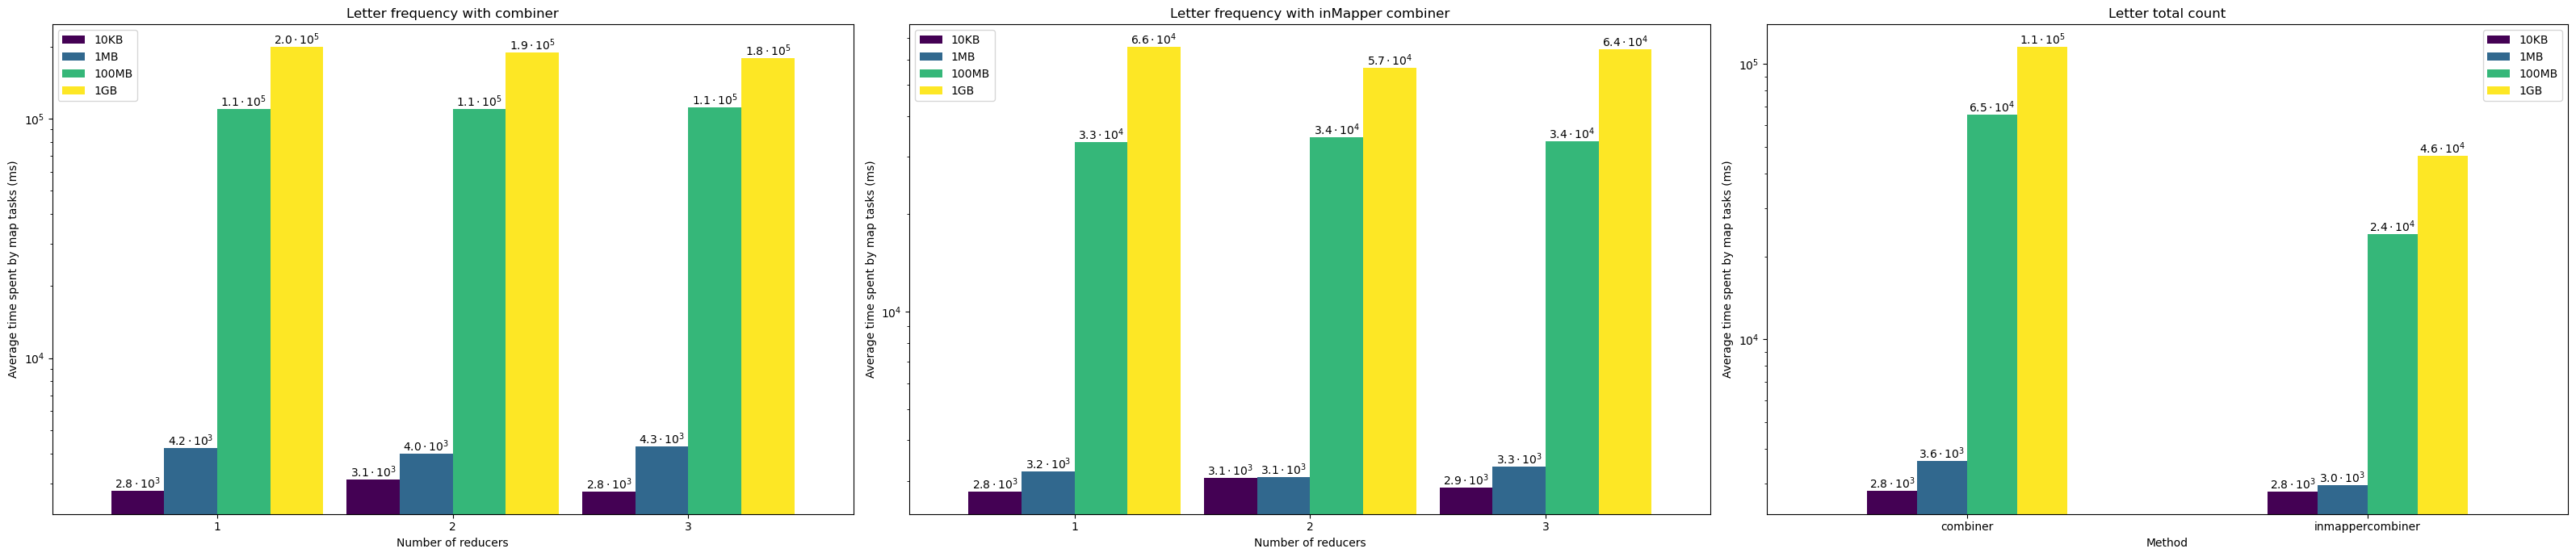

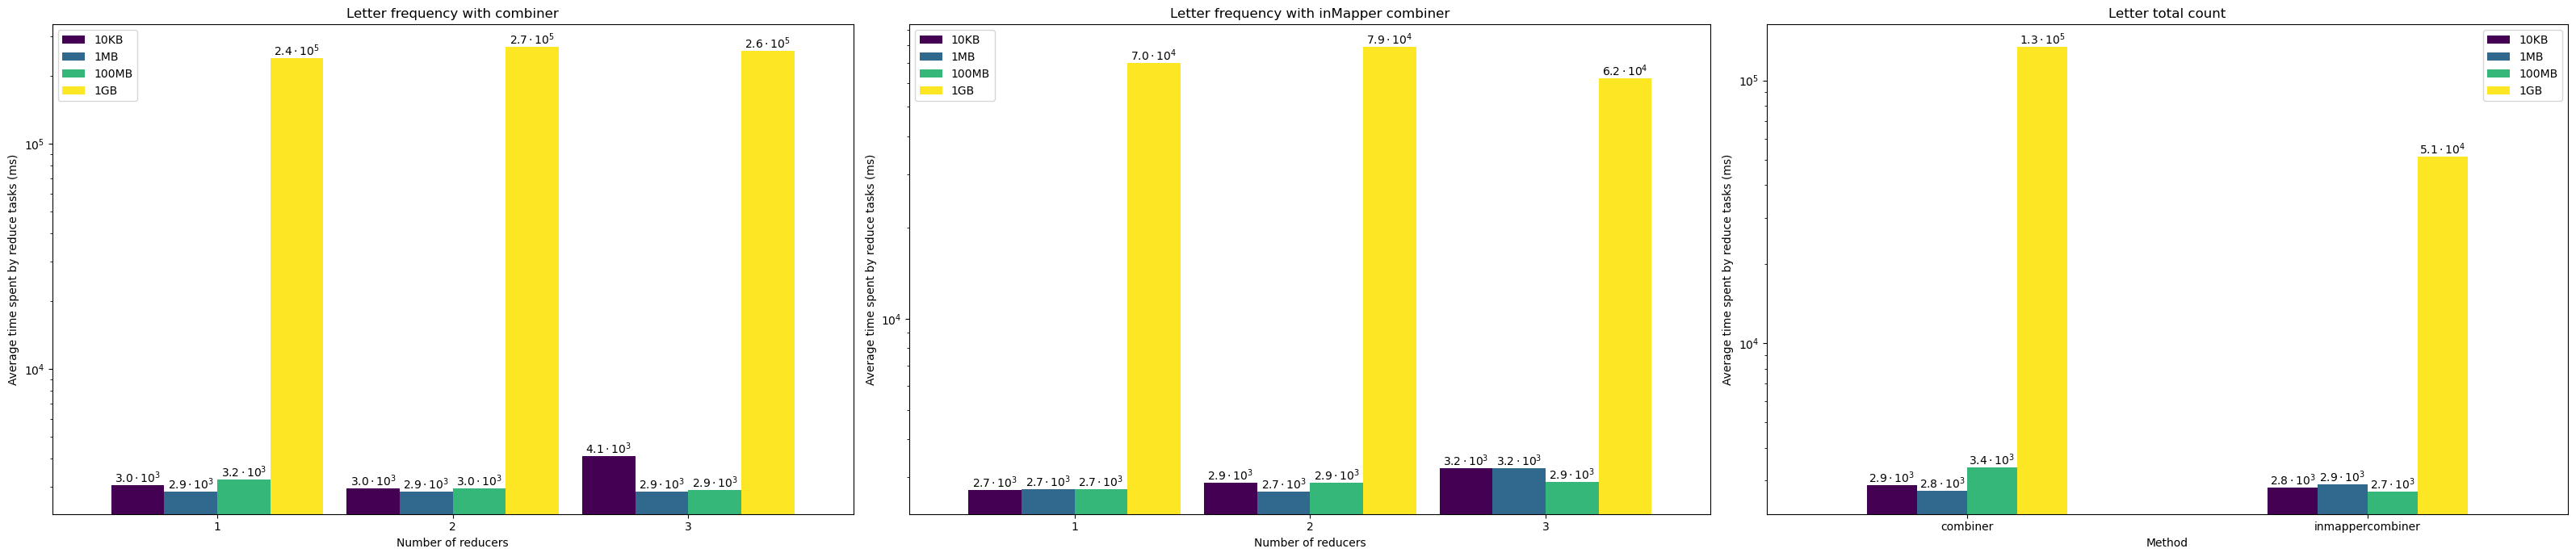

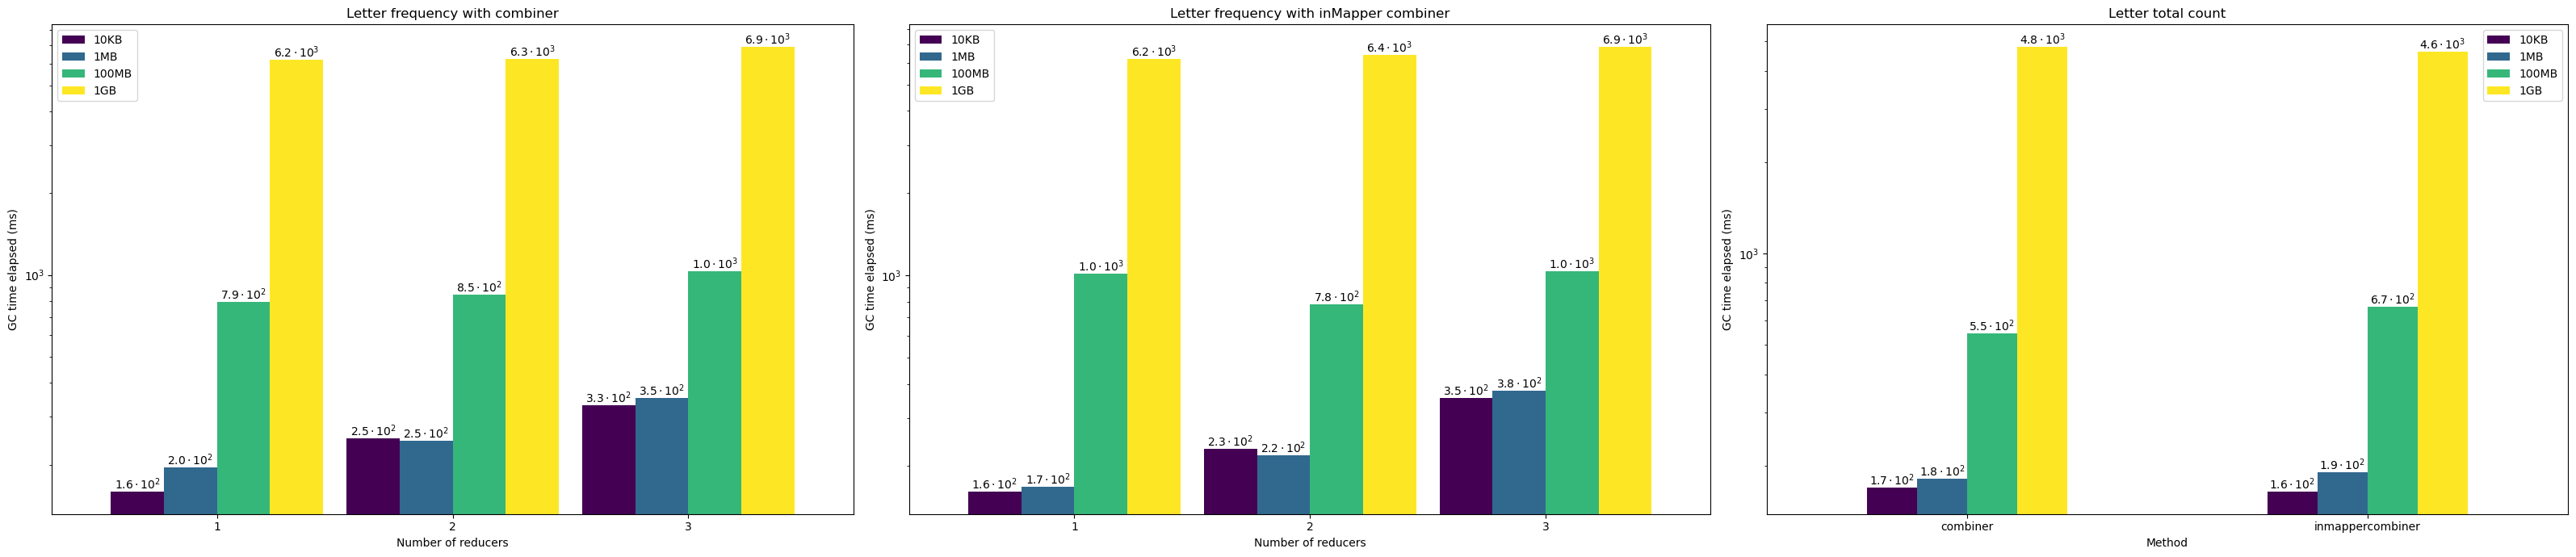

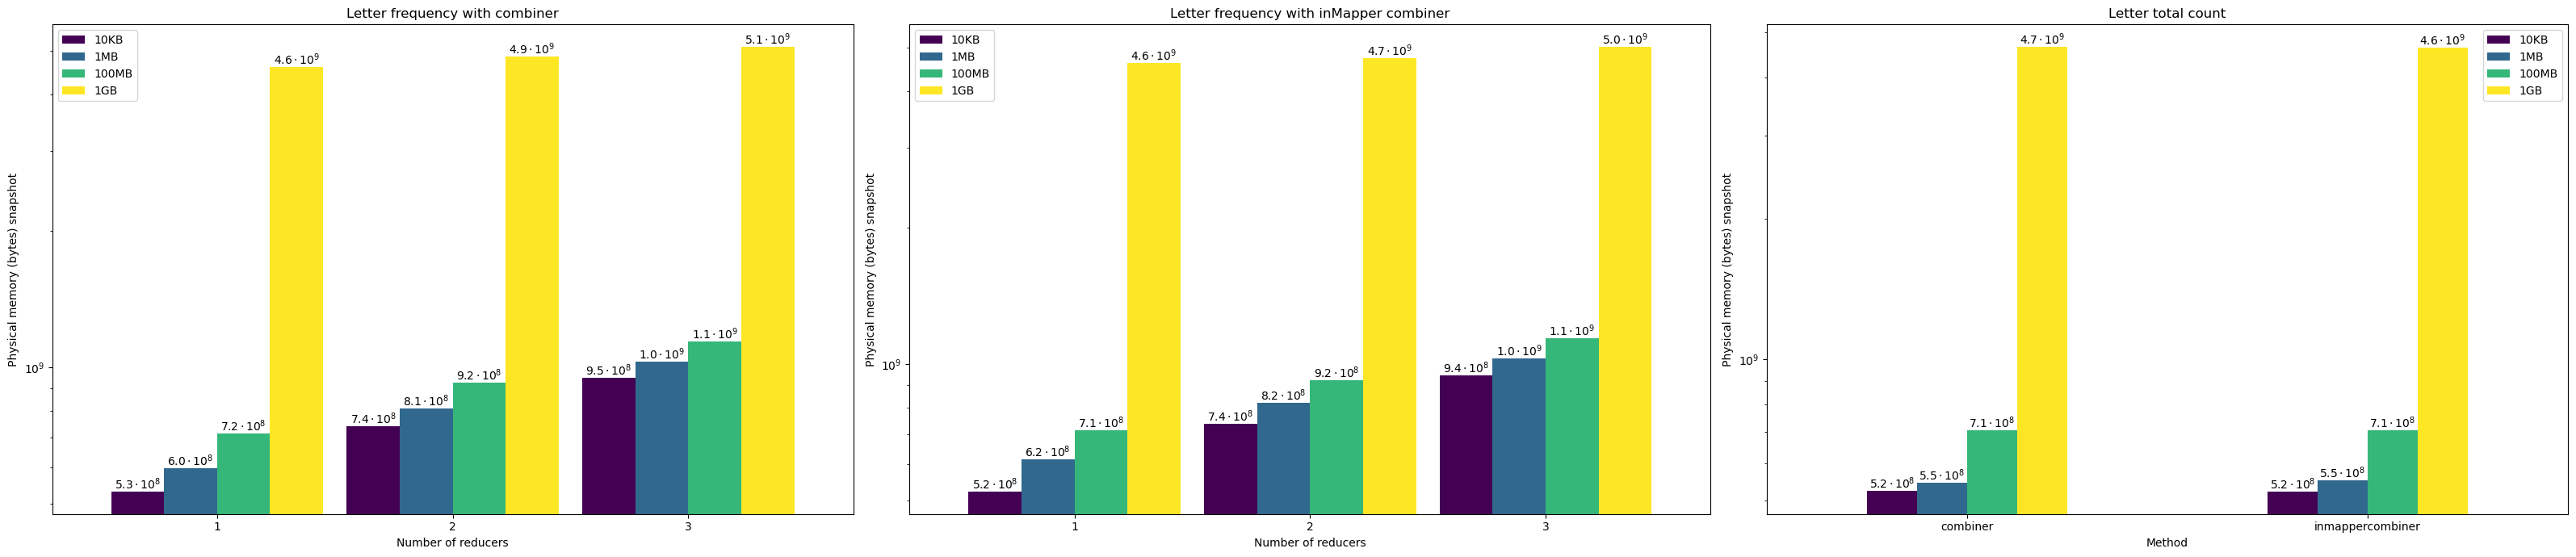

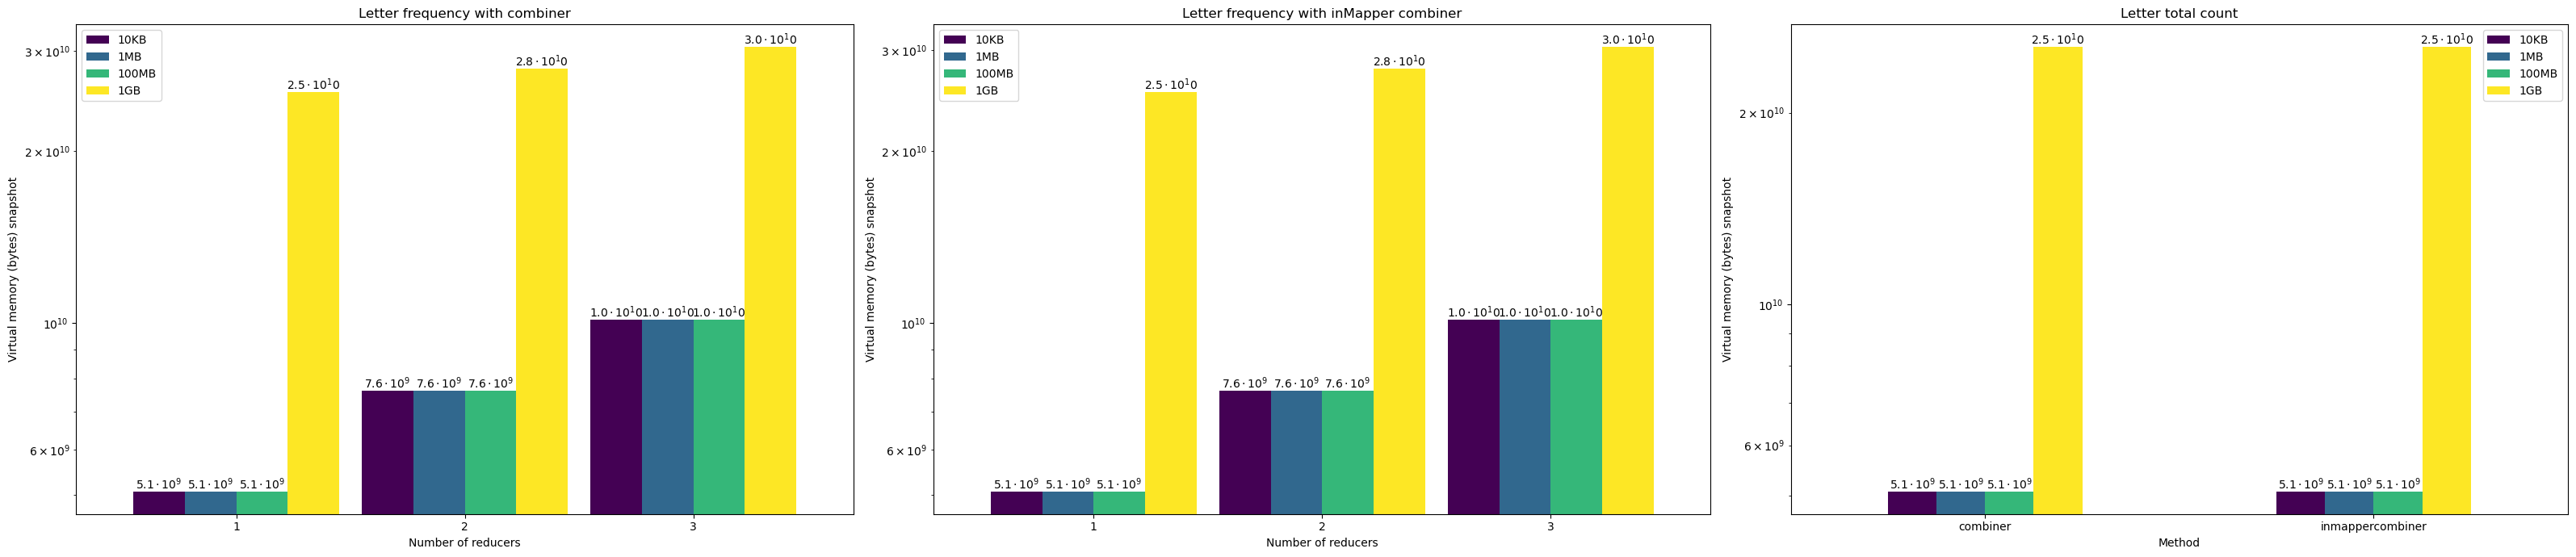

In [7]:
parameters_list = [
    'CPU time spent (ms)', 
    'Launched map tasks',
    'Total time spent by all map tasks (ms)',
    'Total time spent by all reduce tasks (ms)',
    'GC time elapsed (ms)',
    'Physical memory (bytes) snapshot',
	'Virtual memory (bytes) snapshot',
    ]
dim = ['10KB', '1MB', '100MB', '1GB']

launched_map_tasks = [None] * 3

for param in parameters_list:
    # read data of param in each log files
    freq_comb_df = pd.DataFrame(index=range(1, n_reducers+1), columns=dim)
    freq_inmap_df = pd.DataFrame(index=range(1, n_reducers+1), columns=dim)
    count_df = pd.DataFrame(index=methods, columns=dim)
    count_df = count_df.fillna(0)
    for method in methods:
        for i in range(1, n_reducers+1):
            for dim_directory in os.listdir(f'{local_dir}output_{run_id}/{method}_{i}'):
                log_file = f'{local_dir}output_{run_id}/{method}_{i}/{dim_directory}/log.txt'
                is_total_count = True
                with open(log_file, 'r') as f:
                    for line in f:
                        if param in line:
                            if is_total_count:
                                count_df.loc[method, dim_directory] += float(line.split('=')[1])
                                is_total_count = False
                            else:
                                if method == 'combiner':
                                    freq_comb_df.loc[i, dim_directory] = float(line.split('=')[1])
                                else:
                                    freq_inmap_df.loc[i, dim_directory] = float(line.split('=')[1])
                                is_total_count = True           
    count_df = count_df / n_reducers

    if(param == 'Launched map tasks'):
        launched_map_tasks = [freq_comb_df, freq_inmap_df, count_df]
    elif(param == 'Total time spent by all map tasks (ms)'):
        freq_comb_df = freq_comb_df / (launched_map_tasks[0])
        freq_inmap_df = freq_inmap_df / (launched_map_tasks[1])
        count_df = count_df / (launched_map_tasks[2])
        param = 'Average time spent by map tasks (ms)'
    elif(param == 'Total time spent by all reduce tasks (ms)'):
        freq_comb_df = freq_comb_df.div(freq_comb_df.index, axis=0)
        freq_inmap_df = freq_inmap_df.div(freq_inmap_df.index, axis=0)
        param = 'Average time spent by reduce tasks (ms)'

    # plot data
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(32, 7))

    freq_comb_df.plot(kind='bar', title='Letter frequency with combiner', xlabel="Number of reducers", ylabel=f'{param}', rot=0, ax=ax1, colormap='viridis', width=0.9)
    ax1.set_yscale('log')
    for p in ax1.patches:
        coeff, exponent = '{:.2e}'.format(p.get_height()).split('e')
        ax1.annotate(fr'${float(coeff):.1f} \cdot 10^{int(exponent)}$', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    freq_inmap_df.plot(kind='bar', title='Letter frequency with inMapper combiner', xlabel="Number of reducers", ylabel=f'{param}', rot=0, ax=ax2, colormap='viridis', width=0.9)
    ax2.set_yscale('log')
    for p in ax2.patches:
        coeff, exponent = '{:.2e}'.format(p.get_height()).split('e')
        ax2.annotate(fr'${float(coeff):.1f} \cdot 10^{int(exponent)}$', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    count_df.plot(kind='bar', title='Letter total count', xlabel="Method", ylabel=f'{param}', rot=0, ax=ax3, colormap='viridis')
    ax3.set_yscale('log')
    for p in ax3.patches:
        coeff, exponent = '{:.2e}'.format(p.get_height()).split('e')
        ax3.annotate(fr'${float(coeff):.1f} \cdot 10^{int(exponent)}$', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
